## 作業

1. 如何使用已經訓練好的模型？
2. 依照 https://github.com/qqwweee/keras-yolo3 的程式碼，請敘述，訓練模型時，資料集的格式是什麼？具體一點的說，要提供什麼格式的文件來描述資料集的圖片以及 bboxes 的信息呢？





In [1]:
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
# pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [3]:
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

/media/rogerchang/Data/python/cvdl/homework/keras-yolo3


In [4]:
import os
from xml.etree import ElementTree

In [5]:
if not os.path.exists('model_data/yolov3.h5'):
    os.system('wget https://pjreddie.com/media/files/yolov3.weights')
    os.system('python convert.py yolov3.cfg yolov3.weights model_data/yolov3.h5')
else:
    pass

In [6]:
if not os.path.exists('2012_train.txt'):
    sets = [('2012', 'train'), ('2012', 'val')]
    
    classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    
    def dump_info(year, image_id, list_file):
        f = open('VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
        tree = ElementTree.parse(f)
        root = tree.getroot()
        
        for obj in tree.iter('object'):
            diff = int(obj.find('difficult').text)
            cls_name = obj.find('name').text
            
            if cls_name not in classes or diff == 1:
                continue
                
            cls_index = classes.index(cls_name)
            bndbox = obj.find('bndbox')
            
            b = (int(bndbox.find('xmin').text), int(bndbox.find('ymin').text), int(bndbox.find('xmax').text), int(bndbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_index))
            
        f.close()
        
    for year, idd in sets:
        main_anno = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt' % (year, idd))
        anno_path = '%s_%s.txt' % (year, idd)
        list_file = open(anno_path, 'w')
        lines = main_anno.readlines()
        for line in lines:
            line_s = line.strip()
            # print(line_s)
            list_file.write('VOCdevkit/VOC%s/JPEGImages/%s.jpg' % (year, line_s))
            dump_info(year, line_s, list_file)
            list_file.write('\n')
            
        list_file.close()
        main_anno.close()

In [7]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

import time

Using TensorFlow backend.


In [8]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.set_session(sess)

In [9]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [10]:
time.time()

1581762796.9087002

In [11]:
annotation_path = '2012_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/%s/' % str(int(time.time()))# 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolov3.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

Create YOLOv3 model with 9 anchors and 20 classes.


/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/home/rogerchang/anaconda3/env

Load weights model_data/yolov3.h5.
Freeze the first 249 layers of total 252 layers.


In [12]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')


Train on 5146 samples, val on 571 samples, with batch size 4.
Epoch 1/50
1286/1286 [==============================] - 229s 178ms/step - loss: 114.8891 - val_loss: 29.0080
Epoch 2/50
1286/1286 [==============================] - 223s 174ms/step - loss: 27.6229 - val_loss: 25.9780
Epoch 3/50
1286/1286 [==============================] - 221s 172ms/step - loss: 25.0212 - val_loss: 25.1559
Epoch 4/50
1286/1286 [==============================] - 224s 174ms/step - loss: 24.3172 - val_loss: 23.8124
Epoch 5/50
1286/1286 [==============================] - 222s 173ms/step - loss: 23.6298 - val_loss: 23.5562
Epoch 6/50
1286/1286 [==============================] - 220s 171ms/step - loss: 23.3100 - val_loss: 23.3834
Epoch 7/50
1286/1286 [==============================] - 222s 172ms/step - loss: 22.9200 - val_loss: 22.7854
Epoch 8/50
1286/1286 [==============================] - 224s 174ms/step - loss: 22.6796 - val_loss: 22.8926
Epoch 9/50
1286/1286 [==============================] - 220s 171ms/step -

In [13]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 5146 samples, val on 571 samples, with batch size 4.
Epoch 51/100
1286/1286 [==============================] - 329s 256ms/step - loss: 24.1807 - val_loss: 24.2492
Epoch 52/100
1286/1286 [==============================] - 324s 252ms/step - loss: 23.6609 - val_loss: 23.8484
Epoch 53/100
1286/1286 [==============================] - 324s 252ms/step - loss: 23.5733 - val_loss: 24.9375
Epoch 54/100
1286/1286 [==============================] - 324s 252ms/step - loss: 23.4849 - val_loss: 24.1954
Epoch 55/100
1286/1286 [==============================] - 324s 252ms/step - loss: 23.1943 - val_loss: 23.9689

Epoch 00055: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 56/100
1286/1286 [==============================] - 324s 252ms/step - loss: 21.3915 - val_loss: 21.9415
Epoch 57/100
1286/1286 [==============================] - 326s 253ms/step - loss: 20.6273 - val_loss: 22.5712
Epoch 58/100
1286/1286 [==============================] - 3

In [14]:
!wget https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true -O dog.jpg

--2020-02-16 02:10:04--  https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/data/dog.jpg [following]
--2020-02-16 02:10:05--  https://github.com/pjreddie/darknet/raw/master/data/dog.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg [following]
--2020-02-16 02:10:05--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163759 (160K) [image/jpeg]
Saving to: ‘do

In [15]:
from PIL import Image
image = Image.open('dog.jpg')

In [16]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/1581762796/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
dog 0.91 (134, 180) (317, 539)
bicycle 0.99 (199, 129) (565, 444)
1.9336887919998844


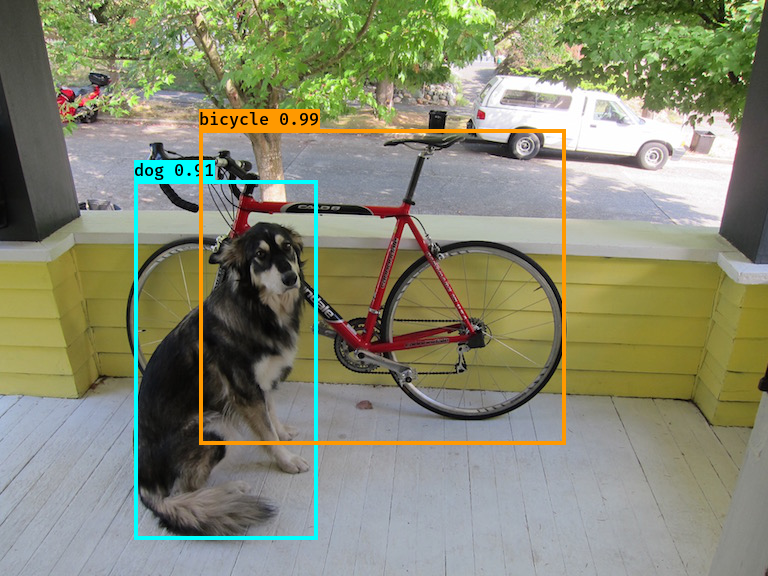

In [17]:
r_image